# Explaining Text Classifiers with Counterfactual Representations 

Dataset: BiasInBios with 'gender' as the manipulated concept (2 concept values)

In [1]:
from concept_erasure import LeaceEraser, LeaceFitter
import torch
import numpy as np
import scipy

from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.neural_network import MLPClassifier,  MLPRegressor
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter


In [2]:
# Global parameters

projection_method = 'orth' # 'orth' or 'leace' ('leace' is the oblique projection from Belrose et al., 2023, LEACE: Perfect linear concept erasure in closed form, NeurIPS 2023)
global_seed = 42 # used for reproductibility
rcond = 1e-5 # used for regressions 

dataset = 'biasbios'
dataset = 'original' 

lin_cl_loss = 'log_loss'
concept_manipulated = 'gender' # 'gender' or 'race'

## LOADING DATA 

- Data is located in the dataset: *./datasets/EEEC/EEEC_3race/*
- **bert** representations for each observations have been pre-calculated using **bert-base-uncased** model (via Huggingface library) and stored in a dictonnary of arrays *D.npz*

## Loading train, validation and test data

In [3]:
base_dir = './datasets/biasbios/'


# Load the original train, validation, test split
with np.load(base_dir + f'D_{dataset}.npz') as balanced_data:
    X, Z_raw, Y_raw = balanced_data['train_X'], balanced_data[f'train_Z_{concept_manipulated}'], balanced_data['train_Y']
    X_test, Z_test_raw, Y_test_raw = balanced_data['test_X'], balanced_data[f'test_Z_{concept_manipulated}'], balanced_data['test_Y']
    
    X_val, Z_val_raw, Y_val_raw =  balanced_data['validation_X'], balanced_data[f'validation_Z_{concept_manipulated}'], balanced_data['validation_Y']


n, d = X.shape # n: number of observations in the train set, d: number of features
n_test, _ = X_test.shape # n_test: number of observations in the test set
n_validation, _ = X_val.shape # n_validation: number of observations in the validation set
z_values = sorted(np.unique(Z_raw)) # list of concept values
k = len(z_values) # number of concept values
y_values = sorted(np.unique(Y_raw)) # list of labels for the downstream task
m = len(y_values) # number of labels for the downstream task

z_label2id = {z_values[i]:i for i in range(len(z_values))}
y_label2id = {y_values[i]:i for i in range(len(y_values))}

Z = np.array([z_label2id[z] for z in Z_raw]).astype(int)
Z_test = np.array([z_label2id[z] for z in Z_test_raw]).astype(int)
Z_val = np.array([z_label2id[z] for z in Z_val_raw]).astype(int)
Y = np.array([y_label2id[y] for y in Y_raw]).astype(int)
Y_test = np.array([y_label2id[y] for y in Y_test_raw]).astype(int)
Y_val =  np.array([y_label2id[y] for y in Y_val_raw]).astype(int)


# Calculate the one hot version of Z
def to_one_hot(A):
        A_1hot = np.zeros((A.size, A.max()+1))
        A_1hot[np.arange(A.size), A] = 1
        return A_1hot
Z_1hot = to_one_hot(Z)

# calculate number of observations per value of Z and Y
z_label2numobs_train = {z_values[i]:np.nonzero([Z==z_label2id[z_values[i]]])[0].shape[0] for i in range(len(z_values))}
z_label2numobs_validation = {z_values[i]:np.nonzero([Z_val==z_label2id[z_values[i]]])[0].shape[0] for i in range(len(z_values))}
z_label2numobs_test = {z_values[i]:np.nonzero([Z_test==z_label2id[z_values[i]]])[0].shape[0] for i in range(len(z_values))}
y_label2numobs_train = {y_values[i]:np.nonzero([Y==y_label2id[y_values[i]]])[0].shape[0] for i in range(len(y_values))}
y_label2numobs_validation = {y_values[i]:np.nonzero([Y_val==y_label2id[y_values[i]]])[0].shape[0] for i in range(len(y_values))}
y_label2numobs_test = {y_values[i]:np.nonzero([Y_test==y_label2id[y_values[i]]])[0].shape[0] for i in range(len(y_values))}

# Display dataset statistics:
print(f''' 
Features:
    d = {d}
Number of observations:
    train: {n}
    validation: {n_validation}
    test: {n_test}
Z labels (protected concept levels): 
    k = {k} 
    mapping: {z_label2id.__str__()}
    num_obs_train: {z_label2numobs_train.__str__()}
    num_obs_validation: {z_label2numobs_validation.__str__()}
    num_obs_test: {z_label2numobs_test.__str__()}
Y labels (downstream task): 
    m = {m}
    mapping: {y_label2id.__str__()}
    num_obs_train: {y_label2numobs_train.__str__()}
    num_obs_validation: {y_label2numobs_validation.__str__()}
    num_obs_test: {y_label2numobs_test.__str__()}
''')

 
Features:
    d = 768
Number of observations:
    train: 255710
    validation: 39369
    test: 98344
Z labels (protected concept levels): 
    k = 2 
    mapping: {'f': 0, 'm': 1}
    num_obs_train: {'f': 117588, 'm': 138122}
    num_obs_validation: {'f': 18804, 'm': 20565}
    num_obs_test: {'f': 45710, 'm': 52634}
Y labels (downstream task): 
    m = 28
    mapping: {'accountant': 0, 'architect': 1, 'attorney': 2, 'chiropractor': 3, 'comedian': 4, 'composer': 5, 'dentist': 6, 'dietitian': 7, 'dj': 8, 'filmmaker': 9, 'interior_designer': 10, 'journalist': 11, 'model': 12, 'nurse': 13, 'painter': 14, 'paralegal': 15, 'pastor': 16, 'personal_trainer': 17, 'photographer': 18, 'physician': 19, 'poet': 20, 'professor': 21, 'psychologist': 22, 'rapper': 23, 'software_engineer': 24, 'surgeon': 25, 'teacher': 26, 'yoga_teacher': 27}
    num_obs_train: {'accountant': 3673, 'architect': 6573, 'attorney': 21194, 'chiropractor': 1688, 'comedian': 1819, 'composer': 3640, 'dentist': 9411, 'dieti

In [4]:
# Displaying correlations in the train set
y_id2label = {int(v):k for k,v in y_label2id.items()}
z_id2label = {int(v):k for k,v in z_label2id.items()}
for i in np.unique(Y):
    for j in np.unique(Z):
        print(f"p(y={y_id2label[i]}|z={z_id2label[j]})={sum(Z[Y==i]==j)/sum(Y==i):.2f}")
    print(' ')

p(y=accountant|z=f)=0.38
p(y=accountant|z=m)=0.62
 
p(y=architect|z=f)=0.25
p(y=architect|z=m)=0.75
 
p(y=attorney|z=f)=0.39
p(y=attorney|z=m)=0.61
 
p(y=chiropractor|z=f)=0.25
p(y=chiropractor|z=m)=0.75
 
p(y=comedian|z=f)=0.21
p(y=comedian|z=m)=0.79
 
p(y=composer|z=f)=0.17
p(y=composer|z=m)=0.83
 
p(y=dentist|z=f)=0.35
p(y=dentist|z=m)=0.65
 
p(y=dietitian|z=f)=0.93
p(y=dietitian|z=m)=0.07
 
p(y=dj|z=f)=0.15
p(y=dj|z=m)=0.85
 
p(y=filmmaker|z=f)=0.34
p(y=filmmaker|z=m)=0.66
 
p(y=interior_designer|z=f)=0.80
p(y=interior_designer|z=m)=0.20
 
p(y=journalist|z=f)=0.50
p(y=journalist|z=m)=0.50
 
p(y=model|z=f)=0.85
p(y=model|z=m)=0.15
 
p(y=nurse|z=f)=0.91
p(y=nurse|z=m)=0.09
 
p(y=painter|z=f)=0.46
p(y=painter|z=m)=0.54
 
p(y=paralegal|z=f)=0.85
p(y=paralegal|z=m)=0.15
 
p(y=pastor|z=f)=0.24
p(y=pastor|z=m)=0.76
 
p(y=personal_trainer|z=f)=0.47
p(y=personal_trainer|z=m)=0.53
 
p(y=photographer|z=f)=0.37
p(y=photographer|z=m)=0.63
 
p(y=physician|z=f)=0.43
p(y=physician|z=m)=0.57
 
p(y=

# Training linear classifiers

$\hat{Y}$: mood state classifier (POMS)

$\hat{Z}$: race classifier (3 values)

Training a POMS linear classifier

In [6]:
def linear_classifier(args, random_state=global_seed):
    lcf = SGDClassifier(
        loss=lin_cl_loss, validation_fraction=0.2, early_stopping=True, random_state=random_state, 
        penalty='l2', max_iter=5000, n_jobs=-1, learning_rate='optimal', warm_start=True, n_iter_no_change=200
    )
    lcf.set_params(**args)
    return lcf

### Training of $\widehat{Y}$

In [135]:
## Uncomment if you want to make a grid search
#
# eta_y = linear_classifier({'alpha': 1e-4})
## parameters = {
#     'alpha':[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
# }
# eta_y = GridSearchCV(eta_y, parameters)

In [7]:
eta_y = linear_classifier({'alpha': 1e-4})
eta_y.fit(X, Y)
print("Train accuracy:", f"{100*eta_y.score(X, Y):.2f}%")
print("Test accuracy: ", f"{100*eta_y.score(X_test, Y_test):.2f}%") 

Train accuracy: 81.66%
Test accuracy:  79.32%


In [11]:
print("Per value accuracy:\n")
y_predicted = eta_y.predict(X)
y_predicted_test = eta_y.predict(X_test)
print("label id", f"{'label name':<20}", "train acc. (%)", "test acc. (%)")
for i in range(m):
    acc_i = np.sum(y_predicted[Y == i] == i) / np.sum([Y == i])
    acc_i_test = np.sum(y_predicted_test[Y_test == i] == i) / np.sum([Y_test == i])
    print(f"{i:<8}",f"{y_id2label[i]:<20}", f"{100*acc_i:<14.2f}", f"{100*acc_i_test:<13.2f}")


Per value accuracy:

label id label name           train acc. (%) test acc. (%)
0        accountant           70.57          63.41        
1        architect            63.32          52.49        
2        attorney             90.13          86.85        
3        chiropractor         51.07          22.50        
4        comedian             80.92          74.96        
5        composer             88.13          88.00        
6        dentist              91.90          90.77        
7        dietitian            78.84          67.91        
8        dj                   72.64          68.73        
9        filmmaker            80.29          78.94        
10       interior_designer    49.05          53.97        
11       journalist           77.89          76.84        
12       model                79.57          69.87        
13       nurse                76.58          77.94        
14       painter              82.14          77.09        
15       paralegal            22.39

### Training of $\widehat{Z}$

In [9]:
## Uncomment if you want to make a grid search
#
# eta_z = linear_classifier({'alpha': 1e-5})
# parameters = {
#     'alpha':[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
# }
# eta_z = GridSearchCV(eta_y, parameters)

In [12]:
eta_z = linear_classifier({'alpha': 1e-5})
eta_z.fit(X, Z)
print("Train accuracy:", f"{100*eta_z.score(X, Z):.2f}%")
print("Test accuracy: ", f"{100*eta_z.score(X_test, Z_test):.2f}%") 

Train accuracy: 99.73%
Test accuracy:  99.35%


In [13]:
print("Per value accuracy:\n")
z_predicted = eta_z.predict(X)
z_predicted_test = eta_z.predict(X_test)
print("label id", f"{'label name':<25}", "train acc. (%)", "test acc. (%)")
for i in range(k):
    acc_i = np.sum(z_predicted[Z == i] == i) / np.sum([Z == i])
    acc_i_test = np.sum(z_predicted_test[Z_test == i] == i) / np.sum([Z_test == i])
    print(f"{i:<8}",f"{z_id2label[i]:<25}", f"{100*acc_i:<14.2f}", f"{100*acc_i_test:<13.2f}")

Per value accuracy:

label id label name                train acc. (%) test acc. (%)
0        f                         99.63          99.16        
1        m                         99.81          99.51        


### Training a non-linear classifier (2-layer MLP) on X

In [18]:
mlpclf_y = MLPClassifier(hidden_layer_sizes=(100, 100), random_state=global_seed, max_iter=300, early_stopping=True).fit(X, Y)
print("Train accuracy:", f"{100*mlpclf_y.score(X, Y):.2f}%")
print("Test accuracy: ", f"{100*mlpclf_y.score(X_test, Y_test):.2f}%") # reminder: train is aggressive, test is balanced

## Concept Erasure

Concept to erase: gender (2 values)\
Erasure method: orthogonal projection on $V^\perp$ (by default) or LEACE oblique projection on $V^\perp$ 

### Erasure

In [14]:
class Erasure:
    
    def __init__(self, projection='orth', rcond=1e-5):
        """
        Parameters: 
        projection (str): 'orth' for an orthogonal projection, 'leace' for an oblique projection using the LEACE projector
        rcond (str): linalg rcond coef
        """
        self.rcond = rcond
        self.projection = projection
        self.P = None
        self.SigXZ = None
        self.E_SigXZ = None
        self.E_P = None
    
    def fit(self, X, Z_1hot):
        self.SigXZ = LeaceFitter.fit(
            torch.Tensor(X),
            torch.Tensor(Z_1hot)
        ).sigma_xz.numpy()
        self.E_SigXZ = scipy.linalg.orth(self.SigXZ, rcond=self.rcond).T

        if self.projection == 'leace':
            self.P = LeaceEraser.fit(
                torch.Tensor(X),
                torch.Tensor(Z_1hot)                    
        ).P.numpy()
        else:
            # I - A (A.T A)^-1 A.T
            self.P = np.eye(self.SigXZ.shape[0]) - self.E_SigXZ.T @ np.linalg.inv(self.E_SigXZ @ self.E_SigXZ.T) @ self.E_SigXZ
        self.E_P = scipy.linalg.orth(self.P, rcond=self.rcond).T
    
    def erase_concept(self, X):
        return X @ self.P.T
    
    def to_vec(self, coordinates, subspace):
        E_subspace = self.E_P if subspace == 'E_P' else self.E_SigXZ
        if len(coordinates.shape) < 2:
            return coordinates[:,np.newaxis] @ E_subspace
        else:
            return coordinates @ E_subspace
    
    def get_coordinates(self, X, subspace):
        E_subspace = self.E_P if subspace == 'E_P' else self.E_SigXZ
        if self.projection == 'leace':
            return (X - X @ self.P.T) @ E_subspace.T.squeeze()
        else:
            return X @ E_subspace.T.squeeze()


In [15]:
LinearErasure = Erasure(projection=projection_method, rcond=rcond)
LinearErasure.fit(X, Z_1hot)
print("Rank of colsp(Sigma_XZ):", LinearErasure.E_SigXZ.shape[0], f"\t(sanity check: must be equal to k-1 = {k-1})")
print("Rank of colsp(P):       ", LinearErasure.E_P.shape[0], f"\t(sanity check: must be equal to d-k+1 = {d-k+1})")

Rank of colsp(Sigma_XZ): 1 	(sanity check: must be equal to k-1 = 1)
Rank of colsp(P):        767 	(sanity check: must be equal to d-k+1 = 767)


### Evaluation of the linear erasure

In [16]:
X_ = LinearErasure.erase_concept(X)
X_test_ = LinearErasure.erase_concept(X_test)

# Check that predicting linearly Z from X_ leads to bad results (concept has been erased linearly)
sgdclass = linear_classifier({'alpha': 1e-4}).fit(X_, Z)
print(f"Accuracy of a linear classifier trained to predict Z from X_orth:")
print("Train accuracy:", f"{100*sgdclass.score(X_,Z):.2f}%")
print("Test accuracy: ", f"{100*sgdclass.score(X_test_, Z_test):.2f}%", f"\t(must be approx. {100/k:.2f}%)\n") 


Accuracy of a linear classifier trained to predict Z from X_orth:
Train accuracy: 54.02%
Test accuracy:  53.52% 	(must be approx. 50.00%)



In [17]:
# Check if a non-linear classifier can predict accurately Z from X_
mlpclf = MLPClassifier(random_state=global_seed, max_iter=300, early_stopping=True).fit(X_, Z)
print(f"Accuracy of a non-linear classifier (2-layer MLP) trained to predict Z from X_orth:")
print("Train accuracy:", f"{100*mlpclf.score(X_,Z):.2f}%")
print("Test accuracy: ", f"{100*mlpclf.score(X_test_, Z_test):.2f}%", f"\t(>> {100/k:.2f}%))")

# Plot the data

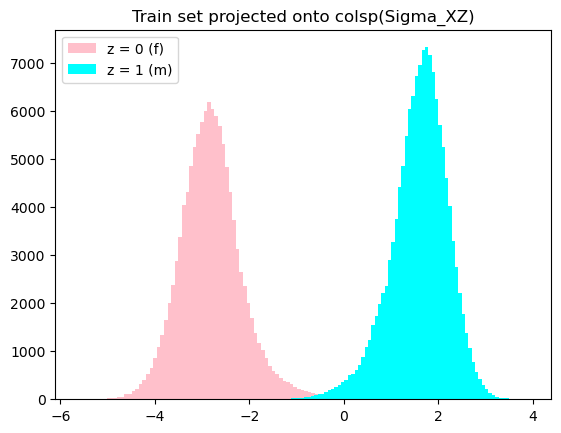

In [19]:
# Plot

# need to add the case where v[0] == 0
def vect_to_equation(v, x, intercept_x = 0):
    y = v[1] / v[0] * (x - intercept_x) 
    return y

lambda_SigXZ = LinearErasure.get_coordinates(X, subspace='E_SigXZ')
mean_lambda = np.mean(lambda_SigXZ)

colors = ['pink', 'cyan']

# Plot the training data points 
for z in np.unique(Z):
    indices = Z == z
    X_SigXZ_z = lambda_SigXZ[indices]
    _ = pyplot.hist(X_SigXZ_z, bins=100, label=f'z = {z} ({z_id2label[z]})', color=colors[z])

_ = pyplot.title('Train set projected onto colsp(Sigma_XZ)')
_ = pyplot.legend()


# Linear reconstruction of $x^\parallel$ with a MSE loss objective

In [20]:
# To improve
# - don't use LEACE library to calculate Sigma_XZ and the LEACE projector

class LinearConceptValueAssignmentWithMSEloss:

    def __init__(self, random_state=global_seed, rcond=rcond):
        self.predictors = {}
        self.noises = {}
        self.LinearErasure = Erasure() # P and Sigma_XZ in it
        self.random_state = random_state
        self.alpha = 5e-2 #orth
        # self.alpha = 1e-4 #leace
        self.lr = 1e-3

    def fit_linear_regression(self, X, Z, linreg_args = {}, validate=False, X_validation=None, Z_validation=None):
        shuffle = True
        validation_fraction = 0.3
        if validate:
            validation_fraction = X_validation.shape[0] / (X.shape[0] + X_validation.shape[0]) 
            X = np.concatenate((X,X_validation), axis=0)
            Z = np.concatenate((Z,Z_validation))
            shuffle = False
        
        X_ = self.LinearErasure.erase_concept(X)
        coord_SigXZ = self.LinearErasure.get_coordinates(X, subspace='E_SigXZ')
        for z in np.unique(Z): 
            linear_regression_mse = MLPRegressor(
                hidden_layer_sizes=(), # linear
                activation="identity",
                max_iter=5000,
                solver='adam',
                early_stopping=True,
                validation_fraction=validation_fraction,
                n_iter_no_change=100,
                alpha=self.alpha,
                learning_rate_init=self.lr,
                random_state=self.random_state,
                warm_start=True,
                shuffle=shuffle
            )
            linear_regression_mse.set_params(**linreg_args)
            linear_regression_mse.fit(X_[Z==z], coord_SigXZ[Z==z])
            self.predictors[z] = linear_regression_mse
        return True

    def fit_gaussian_dispersion(self, X, Z):
        X_ = self.LinearErasure.erase_concept(X)
        coord_SigXZ = self.LinearErasure.get_coordinates(X, subspace='E_SigXZ')
        # Calculate the noise variance per concept value
        for z in np.unique(Z):
            nu_X = self.predictors[z].predict(X_[Z==z])
            noise = coord_SigXZ[Z==z] - nu_X
            if noise.ndim == 1:
                noise = noise.reshape(-1, 1)
            gmm = GaussianMixture(n_components=1, covariance_type='full', max_iter=300)
            gmm.fit(noise)
            self.noises[z] = gmm
        return True

    def fit(self, X, Z, validate=False, X_validation=None, Z_validation=None):
        self.fit_linear_regression(X, Z, validate=validate, X_validation=X_validation, Z_validation=Z_validation)
        self.fit_gaussian_dispersion(X, Z)
        return True
    
    def predict_nu(self, X, Z_assigned):
        X_ = self.LinearErasure.erase_concept(X)
        coord_SigXZ_predicted = np.empty((X.shape[0], self.LinearErasure.E_SigXZ.shape[0]))
        for z in np.unique(Z_assigned):
            indices = Z_assigned == z
            predictions = self.predictors[z].predict(X_[indices])
            if len(predictions.shape) < 2: # predictions must be a matrix with 2 dimensions
                predictions = predictions[:,np.newaxis]
            coord_SigXZ_predicted[indices] = predictions
        X_SigXZ  = self.LinearErasure.to_vec(coord_SigXZ_predicted, subspace='E_SigXZ') 
        return X_ + X_SigXZ


    def predict(self, X, Z_assigned, no_sampling = False):
        X_n_nu = self.predict_nu(X, Z_assigned)
        # Let's sample noise for each observation
        if not no_sampling:
            X_noises_sampled = np.empty(X.shape)
            for z in np.unique(Z_assigned):
                indices = Z_assigned == z
                n_noises = np.sum(indices)
                noises = self.noises[z].sample(n_noises)
                X_noises_sampled[indices] = self.LinearErasure.to_vec(noises[0],subspace='E_SigXZ')
            return X_n_nu + X_noises_sampled
        else:
            return X_n_nu
        
    def score(self, X, Z):
        X_nu = self.predict(X, Z, no_sampling=True) 
        return np.mean(np.linalg.norm(X-X_nu, axis=1))

    def sample_counterfactuals(self, X, z_value, no_sampling=False):
        color = 'blue'
        Z_assigned = np.full((X.shape[0],), z_value)
        X_to_plot = self.predict(X, Z_assigned, no_sampling)
        X_to_plot = self.LinearErasure.get_coordinates(X_to_plot, subspace='E_SigXZ')
        if len(X_to_plot.shape) > 1 and X_to_plot.shape[1] == 2:
            _ = pyplot.scatter(X_to_plot[:,0], X_to_plot[:,1], s=0.1, color=color)
        elif len(X_to_plot.shape) == 1:
            _ = pyplot.hist(X_to_plot[:,], bins=100, color=color)  
    


In [21]:
LCVA_mse = LinearConceptValueAssignmentWithMSEloss(random_state=global_seed)
LCVA_mse.LinearErasure = LinearErasure
LCVA_mse.fit(X,Z, validate=True, X_validation=X_val, Z_validation=Z_val)

True

In [22]:
print("MSE (train):     ", f"{LCVA_mse.score(X, Z):.4f}")
print("MSE (validation):", f"{LCVA_mse.score(X_val, Z_val):.4f}")
print("MSE (test):      ", f"{LCVA_mse.score(X_test, Z_test):.4f}")


MSE (train):      0.1366
MSE (validation): 0.1388
MSE (test):       0.1504


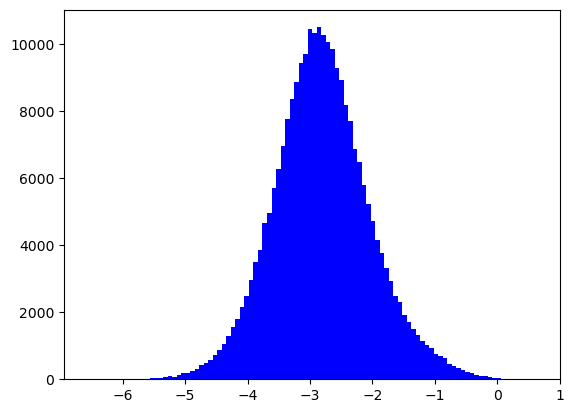

In [24]:
# Sample countefractuals and display them in V^{\parallel}
LCVA_mse.sample_counterfactuals(X, z_value=0, no_sampling=True)

## Evaluations

### $\mathrm{PIP}$ and $\mathrm{ATV}$



From the paper:

Let $\mathcal{S}:=\{(s_i,z_i)\}$ be a set of couples of text documents $s_i$ and of CF values $z_i\neq Z(s_i)$. Define the proportion of identical predictions ($\mathrm{PIP}$) by

$$\mathrm{PIP}_{\widehat{Y}}[\mathcal{S}]:=  \frac{1}{|\mathcal{S}|} \sum_{(s,z)\in\mathcal{S}} \mathbf{1}\left[\widehat{Y}(X(s_{Z\leftarrow z})) = \widehat{Y}(X(s)_{Z\leftarrow z})\right].$$

The range of the \noindent $\mathrm{PIP}$ metric is $[0,1]$, closer to $1$ being better. Similarly, we define $\mathrm{PIP}_{\widehat{Z}}[\mathcal{S}]$.

Let $p_{\widehat{Y}}(x)$ be the probability distribution over $Y$-values used by the classifier $\widehat{Y}$. Define the average total variation (ATV) distance by

$$\mathrm{ATV}_{\widehat{Y}}[\mathcal{S}]:= \frac{1}{|\mathcal{S}|} \sum_{(s,z)\in\mathcal{S}}\underbrace{\frac{1}{2}\big|p_{\widehat{Y}}(X(s_{Z\leftarrow z}))-p_{\widehat{Y}}(X(s)_{Z\leftarrow z})\big|}_{=:\,\mathrm{TV}_{\widehat{Y}}(s,z)}.$$ 

The range of the $\mathrm{ATV}$ metric is $[0,1]$, closer to $0$ being better. Similarly, we define $\mathrm{ATV}_{\widehat{Z}}[\mathcal{S}]$.


### $\mathrm{ATE}$ and $\widehat{\mathrm{ATE}}$

From the paper:

Let's thus define the average treatment effect $\mathrm{ATE}_{\widehat{Y}}$, its estimator $\widehat{\mathrm{ATE}}_{\widehat{Y}}$ defined using the CFRs and the corresponding individual effects

$$\mathrm{ATE}_{\widehat{Y}}[\mathcal{S}]:=\frac{1}{|\mathcal{S}|}\sum_{(s,z)\in\mathcal{S}}\underbrace{\frac{1}{2}\big|p_{\widehat{Y}}(X(s_{Z\leftarrow z})- p_{\widehat{Y}}(X(s))\big|}_{=:\,\mathrm{TE}_{\widehat{Y}}(s,z)} ,$$

$$\widehat{\mathrm{ATE}}_{\widehat{Y}}[\mathcal{S}] := \frac{1}{|\mathcal{S}|}\sum_{(s,z)\in\mathcal{S}} \underbrace{\frac{1}{2}\big|p_{\widehat{Y}}(X(s)_{Z\leftarrow z}- p_{\widehat{Y}}(X(s))\big|}_{=:\,\widehat{\mathrm{TE}}_{\widehat{Y}}(s,z)}.$$

The large braces define the individual treatment effects $\mathrm{TE}_{\widehat{Y}}(s,z)$ and their estimations $\widehat{\mathrm{TE}}_{\widehat{Y}}(s,z)$.

## Evaluating a counterfactual predictor

In [25]:
class CounterfactualClassifier:
    
    def __init__(self, clf, cf_generator, random_state=42):
        self.clf = clf # a classifier 
        self.cf_generator = cf_generator # a countrefactual generator
    

    def cf_predict(self, X, Z_assigned, num_cf=20, no_sampling=False):
        """
        Predicts values using the self.clf classifier from CFRs generated 
        from observations and values of the manipulated attribute to be assigned.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Original data representations.

        Z_assigned: ndarray of shape (n_samples,)
            Counterfactual values of the manipulated attribute to assign.

        num_cf: int (default: 20)
            Number of counterfactuals to sample when CFRs are considered stochastic.
        
        no_sampling: bool (default: False)
            if True CFRs are deterministic, else CFRs are considered stochastic.

        Returns
        -------
        y: ndarray of shape (n_samples,)
            Predictions 
        """
        y_probs_avg = self.cf_predict_proba(X, Z_assigned, num_cf, no_sampling)
        y = np.argmax(y_probs_avg, axis=1)
        return y


    def cf_predict_proba(self, X, Z_assigned, num_cf=20, no_sampling=False):
        """
        Predicts probabilities over Y-values using the local classifier from CFRs generated 
        from observations and values of the manipulated attribute to be assigned.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Original data representations.

        Z_assigned: ndarray of shape (n_samples,)
            Counterfactual values of the manipulated attribute to assign.

        num_cf: int (default: 20)
            Number of counterfactuals to sample when CFRs are considered stochastic.
        
        no_sampling: bool (default: False)
            if True CFRs are deterministic, else CFRs are considered stochastic.

        Returns
        -------
        y: ndarray of shape (n_samples, n_classes)
            Probability distributions over Y-values 
        """
        y_probs_avg = np.zeros((X.shape[0], self.clf.classes_.shape[0]))
        if no_sampling:
            num_cf = 1 
        for _ in range(num_cf):
            X_sampled= self.cf_generator.predict(X, Z_assigned, no_sampling=no_sampling)
            y_probs = self.clf.predict_proba(X_sampled)
            y_probs_avg += y_probs
        return (1/num_cf)*y_probs_avg
    
    def orig_score(self, X, Y):
        return self.clf.score(X, Y)
    
    def orig_predict(self, X):
        return self.clf.predict(X)
    
    def orig_predict_proba(self, X):
        return self.clf.predict_proba(X)


    def evaluate(self, X, Y, X_CF=None, Z_CF=None, Y_CF=None, use_counterfactuals=False):
    
        results = dict()
        y = self.orig_predict(X)
        results["Accuracy"] = self.orig_score(X,Y)
        
        # PIP calculations
        if use_counterfactuals:
            results["Accuracy using CFs"] = self.orig_score(X_CF,Y_CF)
            y_cf = self.orig_predict(X_CF) 
            y_cf_fict_nu_only = self.cf_predict(X, Z_CF, no_sampling=True)
            y_cf_fict_w_sampling = self.cf_predict(X, Z_CF, no_sampling=False)
            results["PIP (CFRs deterministic)"] = np.mean(y_cf == y_cf_fict_nu_only)
            results["PIP (CFRs stochastic)"] = np.mean(y_cf == y_cf_fict_w_sampling)


        # ATE calculations
        ATE = lambda a, b : 0.5*np.mean(np.sum(np.abs(a - b), axis = 1))
        y_cf_fict_probs = self.cf_predict_proba(X, Z_CF, no_sampling=True) # p( X(s)_{Z<-z} )
        y_probs = self.orig_predict_proba(X) # p(X(s))
        results["ATE estimation"] = ATE(y_probs, y_cf_fict_probs) # Estimation of the ATE
        if use_counterfactuals:
            y_cf_probs = self.orig_predict_proba(X_CF) # p( X( s_{Z<-z} ) )
            results["ATE"] = ATE(y_probs, y_cf_probs) # real observations if CFs available
            results["ATV"] = ATE(y_cf_probs, y_cf_fict_probs)
        return results
        
        


In [28]:
Z_CF_test = 1 - Z_test # swapping of the values

In [29]:
cf_clf_y = CounterfactualClassifier(eta_y, LCVA_mse)
results_eta_y = cf_clf_y.evaluate(X_test, Y_test, Z_CF=Z_CF_test, use_counterfactuals=False) # CFs are unavailable for this dataset

In [30]:
for key,value in results_eta_y.items():
    print(f"{key:<25} {value:<20}")

Accuracy                  0.7931546408525177  
ATE estimation            0.08838598804828741 


In [31]:
cf_clf_z = CounterfactualClassifier(eta_z, LCVA_mse)
results_eta_z = cf_clf_z.evaluate(X_test, Z_test, Z_CF=Z_CF_test, use_counterfactuals=False) # CFs are unavailable for this dataset

In [32]:
for key,value in results_eta_z.items():
    print(f"{key:<25} {value:<20}")

Accuracy                  0.9934820629626617  
ATE estimation            0.9772865798322578  


## Data augmentation for bias mitigation

### TPR-GAP (De-Arteaga et al, 2019)

From the paper: 

$$\mathrm{TPR}\text{-Gap}_{z,y} := P[\widehat{Y} = y|Z=z, Y=y] - P[\widehat{Y} = y|Z=\bar{z}, Y=y]$$



In [33]:
def TPR_Gaps(eta, X, Z, Y, ref_z_val, compared_z_val):
    """ 
    Calculate the TPR-Gaps for a z, compared to the counterfactual value z'
    for each Y-value   
    """
    y = eta.predict(X) # model predictions
    filter_z_val = lambda z_val: Z == z_val # filter on Z values
    filter_y_val = lambda y_val: Y == y_val # filter on True Y predictions

    TPR_Gaps = dict()
    for y_val in np.unique(Y):
        TPR_ref = np.mean(
                    y[filter_z_val(ref_z_val)][filter_y_val(y_val)[filter_z_val(ref_z_val)]] == y_val
                )
        TPR_compared = np.mean(
                    y[filter_z_val(compared_z_val)][filter_y_val(y_val)[filter_z_val(compared_z_val)]] == y_val
                )
        TPR_Gaps[y_val] = TPR_ref - TPR_compared
    return TPR_Gaps


def Z_proportions(z_val, Z, Y): # gender imbalance
    filter_y_val = lambda y_val: Y == y_val # filter on True Y predictions
    Z_prop = dict()
    for y_val in np.unique(Y):
        Z_prop[y_val] = np.mean(Z[filter_y_val(y_val)] == z_val)
    return Z_prop

In [35]:
# Let's train a new eta_y_aug on an augmented version of the dataset (adding all counterfactuals)

Z_new = np.mod(np.concatenate([Z+1+i for i in range(k-1)]), k)
Y_new = np.tile(Y, k)

X_new = np.tile(X, (k-1, 1))
X_new = LCVA_mse.predict(X_new, Z_new, no_sampling=True)
X_new = np.concatenate((X, X_new), axis=0)

print("Augmented train set")
print("-----------------")
print("Number of observations:", X_new.shape[0], f"(equals n original + (k-1)*n CFRs = k*n = {k*n})\n")


# Displaying correlations in the augmented train set
print("Correlations in the augmented train set")
print("-----------------")
Z_cat = np.concatenate((Z,Z_new))
for i in np.unique(Y_new):
    for j in np.unique(Z_cat):
        print(f"p(y={y_id2label[i]}|z={z_id2label[j]})={sum(Z_cat[Y_new==i]==j)/sum(Y_new==i):.2f}")
    print(' ')



Augmented train set
-----------------
Number of observations: 511420 (equals n original + (k-1)*n CFRs = k*n = 511420)

Correlations in the augmented train set
-----------------
p(y=accountant|z=f)=0.50
p(y=accountant|z=m)=0.50
 
p(y=architect|z=f)=0.50
p(y=architect|z=m)=0.50
 
p(y=attorney|z=f)=0.50
p(y=attorney|z=m)=0.50
 
p(y=chiropractor|z=f)=0.50
p(y=chiropractor|z=m)=0.50
 
p(y=comedian|z=f)=0.50
p(y=comedian|z=m)=0.50
 
p(y=composer|z=f)=0.50
p(y=composer|z=m)=0.50
 
p(y=dentist|z=f)=0.50
p(y=dentist|z=m)=0.50
 
p(y=dietitian|z=f)=0.50
p(y=dietitian|z=m)=0.50
 
p(y=dj|z=f)=0.50
p(y=dj|z=m)=0.50
 
p(y=filmmaker|z=f)=0.50
p(y=filmmaker|z=m)=0.50
 
p(y=interior_designer|z=f)=0.50
p(y=interior_designer|z=m)=0.50
 
p(y=journalist|z=f)=0.50
p(y=journalist|z=m)=0.50
 
p(y=model|z=f)=0.50
p(y=model|z=m)=0.50
 
p(y=nurse|z=f)=0.50
p(y=nurse|z=m)=0.50
 
p(y=painter|z=f)=0.50
p(y=painter|z=m)=0.50
 
p(y=paralegal|z=f)=0.50
p(y=paralegal|z=m)=0.50
 
p(y=pastor|z=f)=0.50
p(y=pastor|z=m)=0.5

In [39]:
eta_y_aug = linear_classifier({'alpha': 1e-4})
eta_y_aug.fit(X_new, Y_new)

In [40]:
cf_clf_y_aug = CounterfactualClassifier(eta_y_aug, LCVA_mse)
results_eta_y_aug = cf_clf_y_aug.evaluate(X_test, Y_test, Z_CF=Z_CF_test, use_counterfactuals=False) # CFs are unavailable for this dataset
for key,value in results_eta_y_aug.items():
    print(f"{key:<25} {value:<20}")

Accuracy                  0.791029447653136   
ATE estimation            0.0029626057273258693


- No loss in accuracy
- ATE estimation close to 0

In [41]:
# Let's now train a classifer on X^\perp (scrubbed representations)
eta_y_nogender = linear_classifier({'alpha': 1e-4})
eta_y_nogender.fit(X_, Y)

SGDClassifier(early_stopping=True, loss='log_loss', max_iter=5000,
              n_iter_no_change=200, n_jobs=-1, random_state=42,
              validation_fraction=0.2, warm_start=True)

In [42]:
cf_clf_y_nogender = CounterfactualClassifier(eta_y_nogender, LCVA_mse)
results_eta_y_nogender = cf_clf_y_nogender.evaluate(X_test, Y_test, Z_CF=Z_CF_test, use_counterfactuals=False) # CFs are unavailable for this dataset
for key,value in results_eta_y_nogender.items():
    print(f"{key:<25} {value:<20}")

Accuracy                  0.7912938257544945  
ATE estimation            2.2701011738095805e-06


In [67]:
Z_props = Z_proportions(z_label2id['f'], Z_test, Y_test)
y_labels = list(y_label2id.keys())
TPR_gaps_eta_y_orig = TPR_Gaps(eta_y, X_test, Z_test, Y_test, z_label2id['f'], z_label2id['m'])
TPR_gaps_eta_y_nogender = TPR_Gaps(eta_y_nogender, X_test, Z_test, Y_test, z_label2id['f'], z_label2id['m'])
TPR_gaps_eta_y_aug = TPR_Gaps(eta_y_aug, X_test, Z_test, Y_test, z_label2id['f'], z_label2id['m'])
for i in y_labels:
    Z_props[i] = Z_props[y_label2id[i]]
    TPR_gaps_eta_y_orig[i] = TPR_gaps_eta_y_orig[y_label2id[i]]
    TPR_gaps_eta_y_nogender[i] = TPR_gaps_eta_y_nogender[y_label2id[i]]
    TPR_gaps_eta_y_aug[i] = TPR_gaps_eta_y_aug[y_label2id[i]]

print(f"{'occupation':<25} {'TPR-Gap (original)':>20} {'TPR-Gap (augmented)':>20} {'TPR-Gap (scrubbing)':>20} {'Imbalance (%)':>20}")
print(f"{'----------':<25} {'------------------':>20} {'-------------------':>20} {'-------------------':>20} {'-------------':>20}")
# print(f"{i:<25} {TPR_gaps_eta_y_orig[i]:=6.3f} {TPR_gaps_eta_y_aug[i]:=6.3f} {TPR_gaps_eta_y_nogender[i]:=6.3f} {100*Z_props[i]:=6.2f}%")
for i in sorted(y_labels):
    print(f"{i:<25} {TPR_gaps_eta_y_orig[i]:>20.3f} {TPR_gaps_eta_y_aug[i]:>20.3f} {TPR_gaps_eta_y_nogender[i]:>20.3f} {100*Z_props[i]:>20.2f}")

occupation                  TPR-Gap (original)  TPR-Gap (augmented)  TPR-Gap (scrubbing)        Imbalance (%)
----------                  ------------------  -------------------  -------------------        -------------
accountant                              -0.011                0.004               -0.003                33.40
architect                                0.060                0.088                0.089                17.13
attorney                                -0.025               -0.021               -0.021                34.90
chiropractor                            -0.087               -0.075               -0.075                30.05
comedian                                -0.174               -0.137               -0.146                18.60
composer                                -0.058               -0.031               -0.032                13.43
dentist                                  0.022                0.026                0.026                35.76
dietitian 


Weighted avg. of TPR-Gaps (original): 0.06995717681841973
Weighted avg. of TPR-Gaps (nogender): 0.05935304775919639
Weighted avg. of TPR-Gaps (augmented): 0.06007972422929079

Correlation coef. (original): 0.814894323000858
Correlation coef. (nogender): 0.6621092499453569
Correlation coef. (augmented): 0.6924928597765578

Linear regression coef. (original): 0.49866484654108095
Linear regression coef. (nogender): 0.3243003688358968
Linear regression coef. (augmented): 0.36296631027226


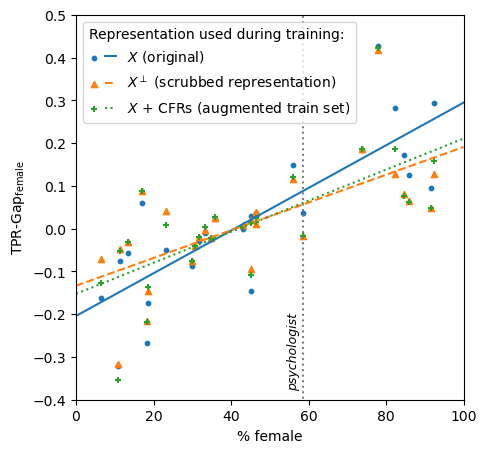

In [73]:
fig, TPR_gaps_linear = pyplot.subplots(1, 1, figsize = (5,5))

x_Z_props = [Z_props[y_label] for y_label in y_labels]
y_TPR_gaps_eta_y_orig = [TPR_gaps_eta_y_orig[y_label] for y_label in y_labels]
y_TPR_gaps_eta_y_nogender = [TPR_gaps_eta_y_nogender[y_label] for y_label in y_labels]
y_TPR_gaps_eta_y_aug = [TPR_gaps_eta_y_aug[y_label] for y_label in y_labels]

linreg_orig = LinearRegression().fit(np.array(x_Z_props).reshape(-1,1), y_TPR_gaps_eta_y_orig)
lin_reg_TPR_gaps_eta_y_orig = linreg_orig.predict([[0], [1]])
linreg_nogender = LinearRegression().fit(np.array(x_Z_props).reshape(-1,1), y_TPR_gaps_eta_y_nogender)
lin_reg_TPR_gaps_eta_y_nogender = linreg_nogender.predict([[0], [1]])
linreg_aug = LinearRegression().fit(np.array(x_Z_props).reshape(-1,1), y_TPR_gaps_eta_y_aug)
lin_reg_TPR_gaps_eta_y_aug = linreg_aug.predict([[0], [1]])


a_scatter = TPR_gaps_linear.scatter(x_Z_props, y_TPR_gaps_eta_y_orig, label='$X$ (original)', s=10)
b_scatter = TPR_gaps_linear.scatter(x_Z_props, y_TPR_gaps_eta_y_nogender, marker='^', label='$X^{\perp}$ (scrubbed representation)', s=20)
c_scatter = TPR_gaps_linear.scatter(x_Z_props, y_TPR_gaps_eta_y_aug, marker='+', label='$X$ + CFRs (augmented train set)', s=20)
a_reg, = TPR_gaps_linear.plot([0,1],lin_reg_TPR_gaps_eta_y_orig, label='$X$ (original)') # '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
b_reg, = TPR_gaps_linear.plot([0,1],lin_reg_TPR_gaps_eta_y_nogender, linestyle='--', label='$X^{\perp}$ (scrubbed representation)')
c_reg, = TPR_gaps_linear.plot([0,1],lin_reg_TPR_gaps_eta_y_aug, linestyle=':', label='$X$ + CFRs (augmented train set)')


# display psychologist
key_psy = "psychologist"
psy, = TPR_gaps_linear.plot([Z_props[key_psy], Z_props[key_psy]], [-1, 1], linestyle=':', color='grey')
TPR_gaps_linear.annotate(f'{key_psy}', xy=(Z_props[key_psy], -0.4), xytext=(Z_props[key_psy]-0.04,-0.37), xycoords='data',rotation=90, fontsize=9, fontstyle='italic')

# limits
for ax in [TPR_gaps_linear]:
    _ = ax.set_ylim([-0.4, 0.5])
    _ = ax.set_xlim([0, 1])
    xticks = sorted([0,20,40, 60, 80, 100])
    xorig = [0,0.2,0.4, 0.6, 0.8, 1]
    _ = ax.set_xticks(xorig, xticks)
    _ = ax.set_xlabel('% female')
    _ = ax.set_ylabel('$\mathrm{TPR}$-Gap$_{\mathrm{female}}$')


from matplotlib.legend_handler import HandlerTuple

l = TPR_gaps_linear.legend([(a_scatter, a_reg), (b_scatter, b_reg), (c_scatter, c_reg)], ['$X$ (original)', '$X^{\perp}$ (scrubbed representation)', '$X$ + CFRs (augmented train set)'], handler_map={tuple: HandlerTuple(ndivide=None)}, title='Representation used during training:', alignment='left')



y_proportions = np.unique(Y_test, return_counts=True)[1][np.array([y_label2id[y_label] for y_label in y_labels])]
# TPR weighted
print('')
print("Weighted avg. of TPR-Gaps (original):", np.sum([abs(y_TPR_gaps_eta_y_orig[i])*y_proportions[i] for i in range(len(y_labels))])/np.sum(y_proportions))
print("Weighted avg. of TPR-Gaps (nogender):",np.sum([abs(y_TPR_gaps_eta_y_nogender[i])*y_proportions[i] for i in range(len(y_labels))])/np.sum(y_proportions))
print("Weighted avg. of TPR-Gaps (augmented):",np.sum([abs(y_TPR_gaps_eta_y_aug[i])*y_proportions[i] for i in range(len(y_labels))])/np.sum(y_proportions))
print('')
print('Correlation coef. (original):', np.corrcoef(x_Z_props, y_TPR_gaps_eta_y_orig)[0,1])
print('Correlation coef. (nogender):', np.corrcoef(x_Z_props, y_TPR_gaps_eta_y_nogender)[0,1])
print('Correlation coef. (augmented):', np.corrcoef(x_Z_props, y_TPR_gaps_eta_y_aug)[0,1])
print('')
print('Linear regression coef. (original):', linreg_orig.coef_[0])
print('Linear regression coef. (nogender):', linreg_nogender.coef_[0])
print('Linear regression coef. (augmented):', linreg_aug.coef_[0])


## Explaining a text classifier

From the paper: 

The bias analysis [...] revolves around a somewhat involved miss-classification rate that we now embark to adapt for our purpose. Let's fix a gender $z$ and two occupations $y_\mathrm{f}\neq y_\mathrm{t}$. First consider the subset of sentences $s$ with a gender $z$ which are misclassified as $y_\mathrm{f}$ when the classifier $\widehat{Y}$ uses the original representation $X(s)$ while it makes a correct prediction $y_\mathrm{t}$ when using the CFR $X(s)_{Z\leftarrow \bar{z}}$ for the swapped gender $\bar{z}$. We next consider the larger subset where we relax the misclassification constraint. We then define a missclassification rate $\widehat{\Pi}_{z,(y_{\mathrm{f}}, y_{\mathrm{t}})}$ as a ratio between the cardinalities of the former to the latter 

$$\widehat{\Pi}_{z,(y_{\mathrm{f}}, y_{\mathrm{t}})} :=  \frac{\left|\left\{ s|\widehat{Y}(X(s))\!=\!y_{\mathrm{f}}, \widehat{Y}(X(s)_{Z\leftarrow \bar{z}})\!=\!Y(s)\!=\!y_{\mathrm{t}}, Z(s)\!=\!z\right\}\right|}{\left|\left\{s|\widehat{Y}(X(s)_{Z\leftarrow \bar{z}})\!=\!Y(s)\!=\!y_{\mathrm{t}}, Z(s)\!=\!z \right\}\right|}.$$

This missclassification rate $\widehat{\Pi}_{z,(y_{\mathrm{f}}, y_{\mathrm{t}})}$ can be thought of as an estimator for a quantity $\Pi_{z,(y_{\mathrm{f}}, y_{\mathrm{t}})}$ defined as in [the above equation] except that the representations $X(s_{Z\leftarrow \bar{z}})$ of the genuine CFs are used instead of the CFRs. At last we define $\widehat{\Pi}^{\text{max}}_z$ as the maximum of  $\widehat{\Pi}_{z,(y_{\mathrm{f}}, y_{\mathrm{t}})}$ over all possible pairs $(y_\mathrm{f}, y_\mathrm{t})$.

In [84]:
def Pi(eta, X, Z, Y, z_label2id=z_label2id, y_label2id=y_label2id, use_fictitious_cf=True):
    y = eta.predict(X)
    if use_fictitious_cf:
        cf_clf = CounterfactualClassifier(eta, LCVA_mse)
        Z_CF_ = (1 - Z).astype(int)
        y_cf = cf_clf.cf_predict(X, Z_CF_, no_sampling=True)
    z_labels=list(z_label2id.keys())
    y_labels=list(y_label2id.keys())
    z_id2label = {v:k for k,v in z_label2id.items()}
    y_id2label = {v:k for k,v in y_label2id.items()}
    # now we have y (prediction from the true obs.), y_cf (prediction from the cf) and Y (ground truth)
    S_g_y1_y2 = {z:{y1:{y2:0 for y2 in y_labels} for y1 in y_labels} for z in z_labels}
    S_g_y2 = {z:{y2:0 for y2 in y_labels} for z in z_labels}
    for (z, y_val, y_cf_val, y_true_val) in zip(Z, y, y_cf, Y):
        if y_true_val == y_cf_val:
            S_g_y2[z_id2label[z]][y_id2label[y_true_val]] += 1 # y2 = y_true
            S_g_y1_y2[z_id2label[z]][y_id2label[y_val]][y_id2label[y_true_val]] += 1 # y1 = y_val
    Pi_out = {z:{y1:{y2:100*S_g_y1_y2[z][y1][y2]/S_g_y2[z][y2] if not S_g_y2[z][y2]==0 else 0 for y2 in y_labels} for y1 in y_labels} for z in z_labels}


    # Display the top 10 Pi
    sorted_ = sorted([(Pi_out[z][y1][y2], z, y1, y2, S_g_y2[z][y2]) for z in z_labels for y1 in y_labels for y2 in y_labels], reverse=True)
    sorted_filtered = [(z,y1,y2,p,n_ex) for (p,z,y1,y2,n_ex) in sorted_ if y1 !=y2]
    male_pi = [f"{a:<6} {b:<20} {c:<20} {d:>#5.2f}  {e:>15}" for (a,b,c,d,e) in sorted_filtered if a == 'm']
    print(f"{'gender':<6} {'false prediction':<20} {'true occupation':<20} {'Pi':>5} {'samples count':>15}")
    print(f"{'------':<6} {'----------------':<20} {'---------------':<20} {'--':>5} {'-------------':>15}")
    _ = [print(s) for s in male_pi[:10]]
    print('')
    female_pi = [f"{a:<6} {b:<20} {c:<20} {d:>#5.2f}  {e:>15}" for (a,b,c,d,e) in sorted_filtered if a == 'f']
    print(f"{'gender':<6} {'false prediction':<20} {'true occupation':<20} {'Pi':>5} {'samples count':>15}")
    print(f"{'------':<6} {'----------------':<20} {'---------------':<20} {'--':>5} {'-------------':>15}")
    _ = [print(s) for s in female_pi[:10]]
    return Pi_out

In [85]:
Pi_ = Pi(eta_y, X_test, Z_test, Y_test)

gender false prediction     true occupation         Pi   samples count
------ ----------------     ---------------         --   -------------
m      architect            interior_designer    38.46               39
m      attorney             paralegal            33.33                6
m      professor            dietitian            13.95               43
m      professor            psychologist          9.54             1269
m      teacher              yoga_teacher          7.50               40
m      professor            teacher               6.03              862
m      surgeon              chiropractor          5.88              102
m      photographer         interior_designer     5.13               39
m      professor            yoga_teacher          5.00               40
m      surgeon              dietitian             4.65               43

gender false prediction     true occupation         Pi   samples count
------ ----------------     ---------------         --   ---------

In [86]:
Pi_ = Pi(eta_y_aug, X_test, Z_test, Y_test)

gender false prediction     true occupation         Pi   samples count
------ ----------------     ---------------         --   -------------
m      architect            software_engineer     0.93             1078
m      professor            teacher               0.64              783
m      professor            pastor                0.36              281
m      psychologist         nurse                 0.34              290
m      professor            accountant            0.34              588
m      professor            software_engineer     0.28             1078
m      professor            physician             0.26             1953
m      rapper               comedian              0.23              440
m      model                comedian              0.23              440
m      filmmaker            comedian              0.23              440

gender false prediction     true occupation         Pi   samples count
------ ----------------     ---------------         --   ---------

In [87]:
Pi_ = Pi(eta_y_nogender, X_test, Z_test, Y_test)

gender false prediction     true occupation         Pi   samples count
------ ----------------     ---------------         --   -------------
m      yoga_teacher         teacher               0.00              781
m      yoga_teacher         surgeon               0.00             1642
m      yoga_teacher         software_engineer     0.00             1083
m      yoga_teacher         rapper                0.00              266
m      yoga_teacher         psychologist          0.00             1154
m      yoga_teacher         professor             0.00            14867
m      yoga_teacher         poet                  0.00              698
m      yoga_teacher         physician             0.00             1945
m      yoga_teacher         photographer          0.00             3654
m      yoga_teacher         personal_trainer      0.00              136

gender false prediction     true occupation         Pi   samples count
------ ----------------     ---------------         --   ---------